# Getting the data


## Connecting to Google Drive
Link my google drive to deposit files there

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


**open class names file** and read each line into a list

*we could pick different class names evey time, just by picking a different txt file*

In [0]:
file = open('/content/gdrive/My Drive/S19/SSW 215/Project SSW215/small_class_names.txt')
classes = file.readlines()
file.close

<function TextIOWrapper.close>

In [0]:
print(classes)

['drums\n', 'sun\n', 'laptop\n', 'book\n', 'traffic_light\n', 'wristwatch\n', 'wheel\n', 'shovel\n', 'cake\n', 'clock\n', 'broom\n', 'crown\n', 'cactus\n', 'car\n', 'bicycle\n', 'donut']


How does the list look like?
The list contains *new line* indicators, remove them



In [0]:
classes = [c.replace('\n', '').replace(' ', '_') for c in classes]

the new list of class names is clean!

In [0]:
print(classes)

['drums', 'sun', 'laptop', 'book', 'traffic_light', 'wristwatch', 'wheel', 'shovel', 'cake', 'clock', 'broom', 'crown', 'cactus', 'car', 'bicycle', 'donut']


## Import the data

1.   Make a new folder called `data` to put images there
2.   Use `urllib.request` to bring the data from the google api
3.   Iterate through items in the `classes` list we created above, and bring in only the data for those things





In [0]:
!mkdir data

In [0]:
import urllib.request
def download_image_files():
  location = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20') #replace spaces with %20 because thats how it is with urls
    path = location+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/' + c + '.npy')

In [0]:
download_image_files()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wheel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/shovel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cake.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broom.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/crown.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bit

At this point, all image files (in the form of NumPy objects) have been loaded to the `data` folder.

## Load the .npy files

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
  all_files = glob.glob(os.path.join(root, '*.npy'))
  
  #initialize variables
  x = np.empty([0, 784]) #784 is 28x8, the shape of our flattened image. Creates a 0,784 matrix of really small random numbers
  y = np.empty([0])
  class_names = []
  
  #load each data file
  for idx, file in enumerate(all_files):
    data = np.load(file) #place numpy file into data
    data = data[0:max_items_per_class, :] # only use the first X items per class
    labels = np.full(data.shape[0], idx)# ??
    
    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)
    
    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)
  
  data = None
  labels = None

  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #separate into training and testing 
  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]
  return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')

Set values for the:

*   Number of classes (categories)
*   Image size 




In [0]:
num_classes = len(class_names)
image_size = 28

**Run the cell below to see a random data point!**



book


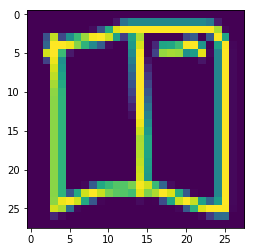

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline


idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) #change this to variables
print(class_names[int(y_train[idx].item())])



# Building a neural network from the labeled data

## Preprocessing the data

### Reshape the data

Currently each image's data is stored flattened as a 784 element array. All 51200 images are in the same x_train matrix:


In [0]:
x_train.shape # as imported

(51200, 784)

In [0]:
# Reshape 
x_train = x_train.reshape(x_train.shape[0], image_size, image_size,1).astype('float32') # reshape arrays to 28x28 matrices of floats
x_test = x_test.reshape(x_test.shape[0], image_size, image_size,1).astype('float32')

In [0]:
x_train.shape # after reshaping

(51200, 28, 28, 1)

### Normalize the data

In machine learning, you don't want to have data of very different dimensions because it slows down learning. Better to divide data by the max to normalize (make every entry a value between 0 and 1)

In [0]:
print(x_train.max()) # before normalization the max value (pure black) is 255

255.0


In [0]:
# Normalize
x_train /= 255.0 # divide each entry of the matrix by 255 so it becomes a float between 0 and 1
x_test /= 255.0

### Reshape the labels

Current labels are placed in an array of size `0, training_examples`.

Convert labels to a matrix of size `(training_examples, num_classes`), with 1 in the position of the correct labels, and 0 elsewhere.

In [0]:
# before the reshaping is an array. After reshaping is a 0,1 matrix:
print("the shape of y_train is: ")
print(y_train.shape)

print("a sample of y_train")
print(y_train)

the shape of y_train is: 
(51200,)
a sample of y_train
[ 8. 10.  4. ...  3. 12.  6.]


In [0]:
# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes) # Converts label array to a matrix of 0,0,0 with 1's in the correct label
y_test = keras.utils.to_categorical(y_test, num_classes)

## Building the Skeleton of the model

In [0]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='softmax')) 
# Train model
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flat

In [0]:
print(y_train.shape)

(51200, 16)


## Train, test and save the NN

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=1)

Train on 46080 samples, validate on 5120 samples
Instructions for updating:
Use tf.cast instead.
 - 5s - loss: 1.1000 - top_k_categorical_accuracy: 0.9069 - val_loss: 0.5973 - val_top_k_categorical_accuracy: 0.9701


### Test the accuracy

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)
print('The test accuracy of this model is: {:0.2f}%'.format(score[1] * 100))

12800/12800 [==============================] - 1s 83us/sample - loss: 0.6302 - top_k_categorical_accuracy: 0.9684
The test accuracy of this model is: 96.84%


### Save and export

In [0]:
model.save('keras.h5')

In [0]:
!pip install tensorflowjs

    100% |████████████████████████████████| 13.9MB 3.4MB/s 
    100% |████████████████████████████████| 86.8MB 411kB/s 
    100% |████████████████████████████████| 81kB 3.1MB/s 
    100% |████████████████████████████████| 3.1MB 7.4MB/s 
    100% |████████████████████████████████| 61kB 22.8MB/s 
    100% |████████████████████████████████| 430kB 20.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
s3fs 0.2.1 has requirement six>=1.12.0, but you'll have six 1.11.0 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.16 which is incompatible.
google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is inc

In [0]:
!mkdir "gdrive/My Drive/S19/SSW 215/Project SSW215/model"

mkdir: cannot create directory ‘gdrive/My Drive/S19/SSW 215/Project SSW215/model’: File exists


In [0]:
!tensorflowjs_converter --input_format keras keras.h5 model/

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'


In [0]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 8%)
  adding: model/model.json (deflated 82%)


In [0]:
# drive.mount("/content/gdrive", force_remount=True)
from google.colab import files
files.download("/content/model.zip")


# Run a new data point

### Open the trained model

In [0]:
# from google.colab import files
open('gdrive/My Drive/S19/SSW 215/Project SSW215/model/model.zip')

<_io.TextIOWrapper name='gdrive/My Drive/S19/SSW 215/Project SSW215/model/model.zip' mode='r' encoding='UTF-8'>

### Predict
Run the new data point through the model and predict the label

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open("gdrive/My Drive/S19/SSW 215/Project SSW215/image.ps")
img.save("image.png", format="png")

img = Image.open("image.png")
img = img.resize((112, 112), Image.ANTIALIAS)
img = img.resize((28,28))
img.save("image.png")

img = Image.open("image.png")
np_img = np.array(img)
np_img = np_img[:,:,0]
np_img = abs(np_img-255)

print(np_img.shape)
print(np_img)
plt.imshow(np_img)

FileNotFoundError: ignored

cake


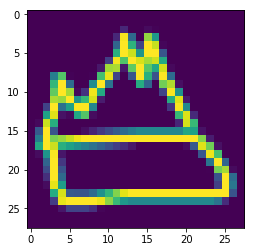

In [0]:

X_new = x_test[134].reshape(1,28,28,1) #select a new data point from the test set

plt.imshow(X_new.reshape(28,28)) # print it just so we can see it --this does nothing to the prediction

Y_new_idx = (int(np.argmax(model.predict(X_new)))) # model.predict gets the array of 0's and 1's, from there, get the index of the 1 and convert it to an int

print(class_names[Y_new_idx]) # uses the index above to get the right image name


In [0]:
print(x_test[134].shape)